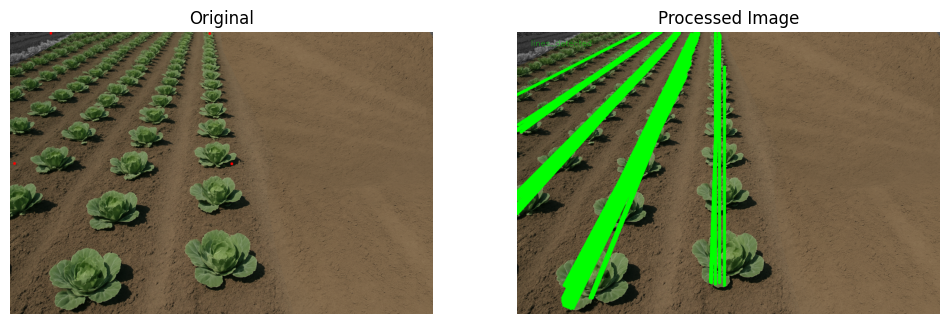

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img = cv2.imread("cropai.png")
original = img.copy()

# Draw reference points
cv2.circle(original, (148, 4), 5, (0, 0, 255), -1)
cv2.circle(original, (725, 5), 5, (0, 0, 255), -1)
cv2.circle(original, (16, 477), 5, (0, 0, 255), -1)
cv2.circle(original, (805, 478), 5, (0, 0, 255), -1)

# #Perspective transform
# pts1 = np.float32([[148, 4], [725, 5], [16, 477], [805, 478]])
# pts2 = np.float32([[0, 0], [400, 0], [0, 600], [400, 600]])
# matrix = cv2.getPerspectiveTransform(pts1, pts2)
# img = cv2.warpPerspective(img, matrix, (500, 600))

# Mask setup (currently blank)
mask = np.zeros(img.shape, dtype=np.uint8)
channel_count = img.shape[2]
ignore_mask_color = (255,) * channel_count
masked_image = cv2.bitwise_and(img, mask)
img2 = cv2.subtract(img, masked_image)

# HSV thresholding
hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
lower_blue = np.array([45, 62, 52])
upper_blue = np.array([72, 255, 255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)
result = cv2.bitwise_and(img2, img2, mask=mask)

# Skeletonization
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
edges = gray
skel = np.zeros(edges.shape, np.uint8)
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

while True:
    open_img = cv2.morphologyEx(edges, cv2.MORPH_OPEN, element)
    temp = cv2.subtract(edges, open_img)
    eroded = cv2.erode(edges, element)
    skel = cv2.bitwise_or(skel, temp)
    edges = eroded.copy()
    if cv2.countNonZero(edges) == 0:
        break

# Hough Line detection
lines = cv2.HoughLinesP(skel, 4, np.pi / 180, 1000, maxLineGap=1500)

if lines is None:
    print("Line Not Detected")
else:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 10)
        cv2.putText(img, 'lines_detected', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
        # print("Line Detected")

# Convert BGR to RGB for display in matplotlib
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
processed_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display images using matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_rgb)
plt.title('Processed Image')
plt.axis('off')

plt.show()
